In [2]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
import tensorflow as tf 
import re 
from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow as tf
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
import seaborn as sns 
plt.style.use('ggplot')

In [3]:
#fake_df = pd.read_csv('../input/fake-and-real-news-dataset/Fake.csv')
fake_df = pd.read_csv('/kaggle/input/d/juhipathak323/fake-news-dataset/Fake.csv')
real_df = pd.read_csv('/kaggle/input/d/juhipathak323/fake-news-dataset/True.csv')
#real_df = pd.read_csv('../input/fake-and-real-news-dataset/True.csv')

In [4]:
fake_df.isnull().sum()

title      0
text       0
subject    0
date       0
dtype: int64

In [5]:
real_df.isnull().sum()

title      0
text       0
subject    0
date       0
dtype: int64

In [6]:
fake_df.subject.unique()

array(['News', 'politics', 'Government News', 'left-news', 'US_News',
       'Middle-east'], dtype=object)

In [7]:
real_df.subject.unique()

array(['politicsNews', 'worldnews'], dtype=object)

In [11]:
fake_df.drop(['date', 'subject'], axis=1, inplace=True)
real_df.drop(['date', 'subject'], axis=1, inplace=True)

KeyError: "['date' 'subject'] not found in axis"

In [8]:
fake_df['class'] = 0 
real_df['class'] = 1

Text(0, 0.5, 'Proportion of News Articles')

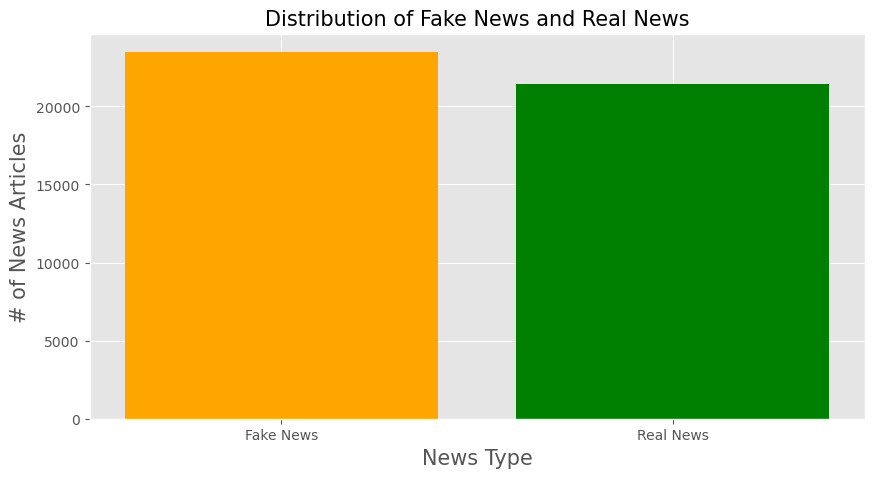

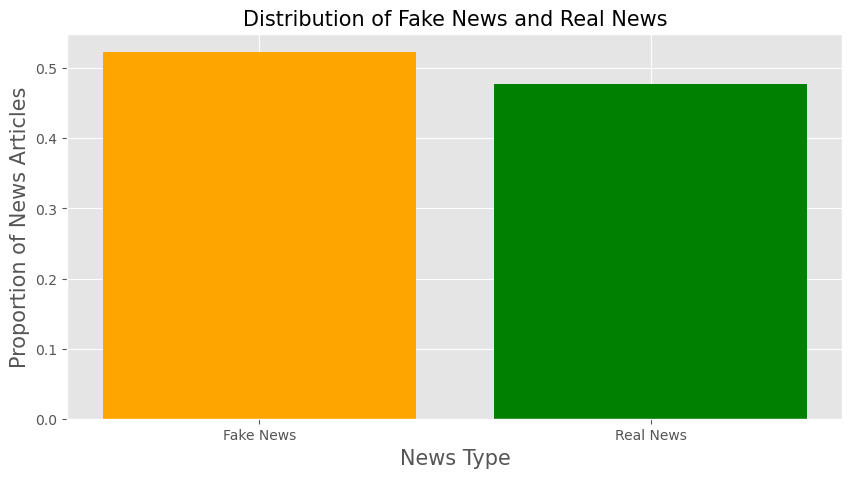

In [9]:
plt.figure(figsize=(10, 5))
plt.bar('Fake News', len(fake_df), color='orange')
plt.bar('Real News', len(real_df), color='green')
plt.title('Distribution of Fake News and Real News', size=15)
plt.xlabel('News Type', size=15)
plt.ylabel('# of News Articles', size=15)


total_len = len(fake_df) + len(real_df)
plt.figure(figsize=(10, 5))
plt.bar('Fake News', len(fake_df) / total_len, color='orange')
plt.bar('Real News', len(real_df) / total_len, color='green')
plt.title('Distribution of Fake News and Real News', size=15)
plt.xlabel('News Type', size=15)
plt.ylabel('Proportion of News Articles', size=15)

In [10]:
print('Difference in news articles:',len(fake_df)-len(real_df))

Difference in news articles: 2064


In [11]:
news_df = pd.concat([fake_df, real_df], ignore_index=True, sort=False)
news_df

,title,text,subject,date,class
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0
...,...,...,...,...,...
44893,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,"August 22, 2017",1
44894,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,"August 22, 2017",1
44895,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,"August 22, 2017",1
44896,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,"August 22, 2017",1


In [12]:
news_df['text'] = news_df['title'] + news_df['text']
news_df.drop('title', axis=1, inplace=True)

In [13]:
features = news_df['text']
targets = news_df['class']

X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.20, random_state=18)

In [14]:
def normalize(data):
    normalized = []
    for i in data:
        i = i.lower()
        # get rid of urls
        i = re.sub('https?://\S+|www\.\S+', '', i)
        # get rid of non words and extra spaces
        i = re.sub('\\W', ' ', i)
        i = re.sub('\n', '', i)
        i = re.sub(' +', ' ', i)
        i = re.sub('^ ', '', i)
        i = re.sub(' $', '', i)
        normalized.append(i)
    return normalized

X_train = normalize(X_train)
X_test = normalize(X_test)

In [15]:
max_vocab = 10000
tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(X_train)

In [16]:
# tokenize the text into vectors 
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [17]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, padding='post', maxlen=256)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, padding='post', maxlen=256)

In [18]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_vocab, 128),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         1280000   
                                                                 
 bidirectional (Bidirectiona  (None, None, 128)        98816     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 32)               18560     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 6

In [19]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=4,validation_split=0.1, batch_size=30, shuffle=True, callbacks=[early_stop])

Epoch 1/4
1078/1078 [==============================] - 366s 332ms/step - loss: 0.2405 - accuracy: 0.8831 - val_loss: 0.0564 - val_accuracy: 0.9833
Epoch 2/4
1078/1078 [==============================] - 367s 341ms/step - loss: 0.0388 - accuracy: 0.9899 - val_loss: 0.0303 - val_accuracy: 0.9914
Epoch 3/4
1078/1078 [==============================] - 364s 337ms/step - loss: 0.0265 - accuracy: 0.9929 - val_loss: 0.0355 - val_accuracy: 0.9889
Epoch 4/4
1078/1078 [==============================] - 367s 340ms/step - loss: 0.0165 - accuracy: 0.9962 - val_loss: 0.0246 - val_accuracy: 0.9922


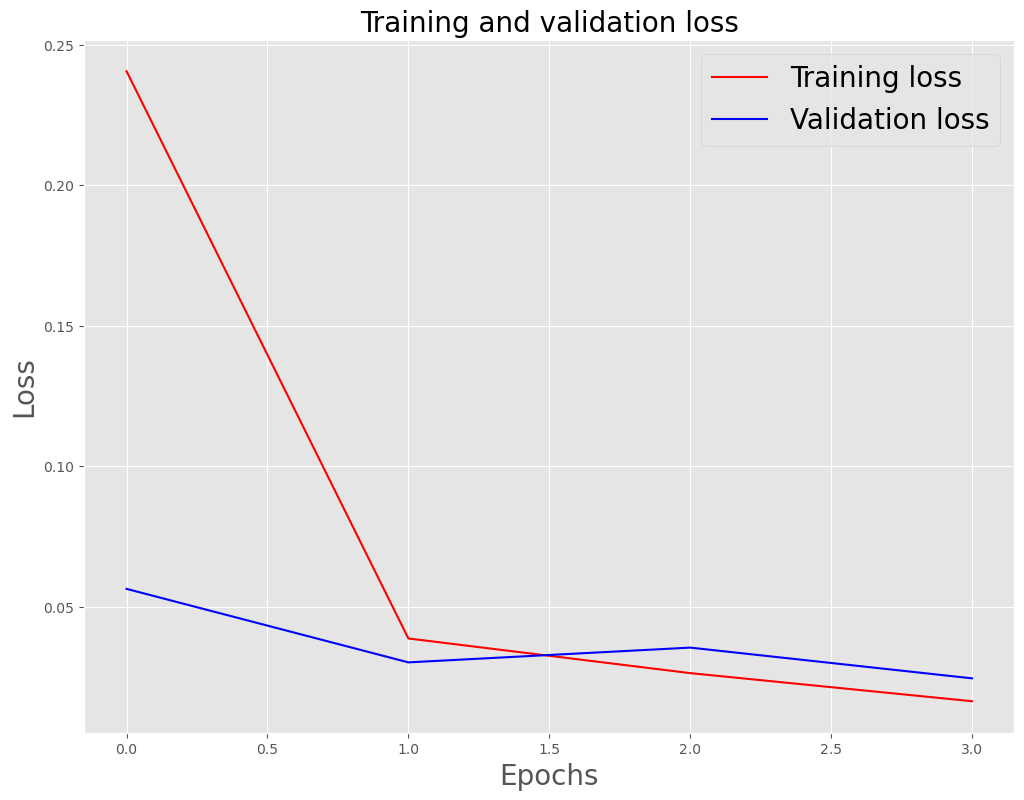

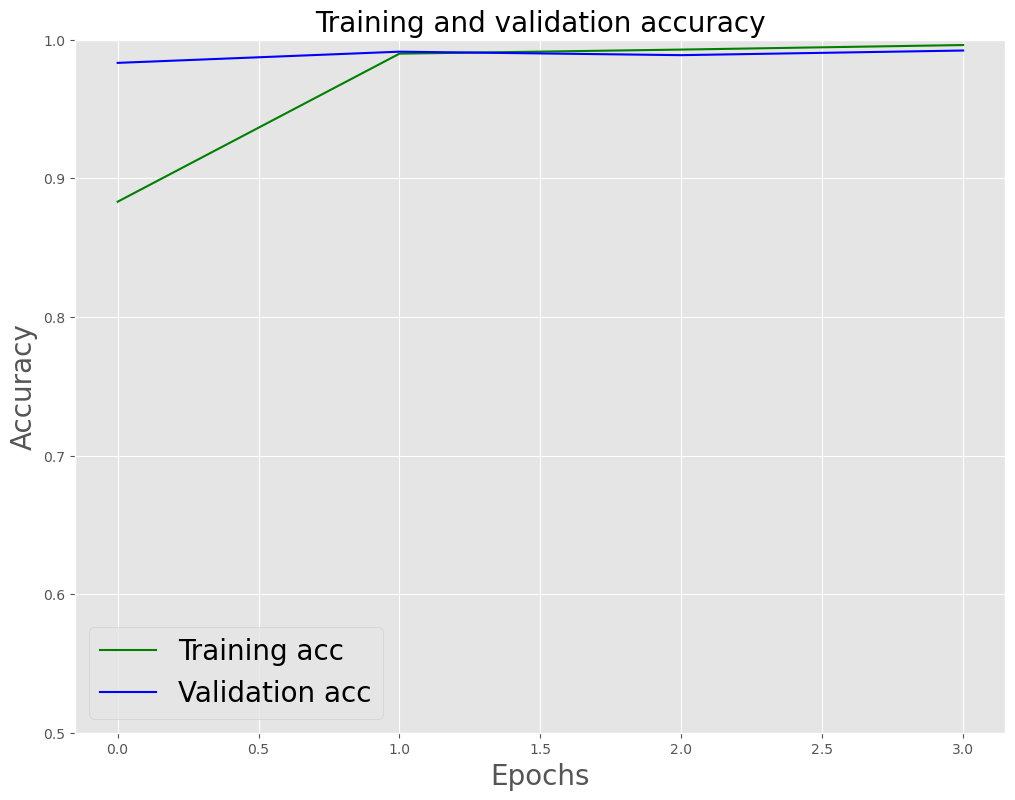

In [20]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = history.epoch

plt.figure(figsize=(12,9))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Loss', size=20)
plt.legend(prop={'size': 20})
plt.show()

plt.figure(figsize=(12,9))
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Accuracy', size=20)
plt.legend(prop={'size': 20})
plt.ylim((0.5,1))
plt.show()

In [21]:
model.evaluate(X_test, y_test)

281/281 [==============================] - 23s 83ms/step - loss: 0.0269 - accuracy: 0.9921


[0.026871535927057266, 0.992093563079834]

In [22]:
pred = model.predict(X_test)

binary_predictions = []

for i in pred:
    if i >= 0.5:
        binary_predictions.append(1)
    else:
        binary_predictions.append(0)

281/281 [==============================] - 24s 81ms/step


In [23]:
print('Accuracy on testing set:', accuracy_score(binary_predictions, y_test))
print('Precision on testing set:', precision_score(binary_predictions, y_test))
print('Recall on testing set:', recall_score(binary_predictions, y_test))

Accuracy on testing set: 0.9920935412026726
Precision on testing set: 0.9886521537748958
Recall on testing set: 0.9948729899790258


[Text(0, 0.5, '0'), Text(0, 1.5, '1')]

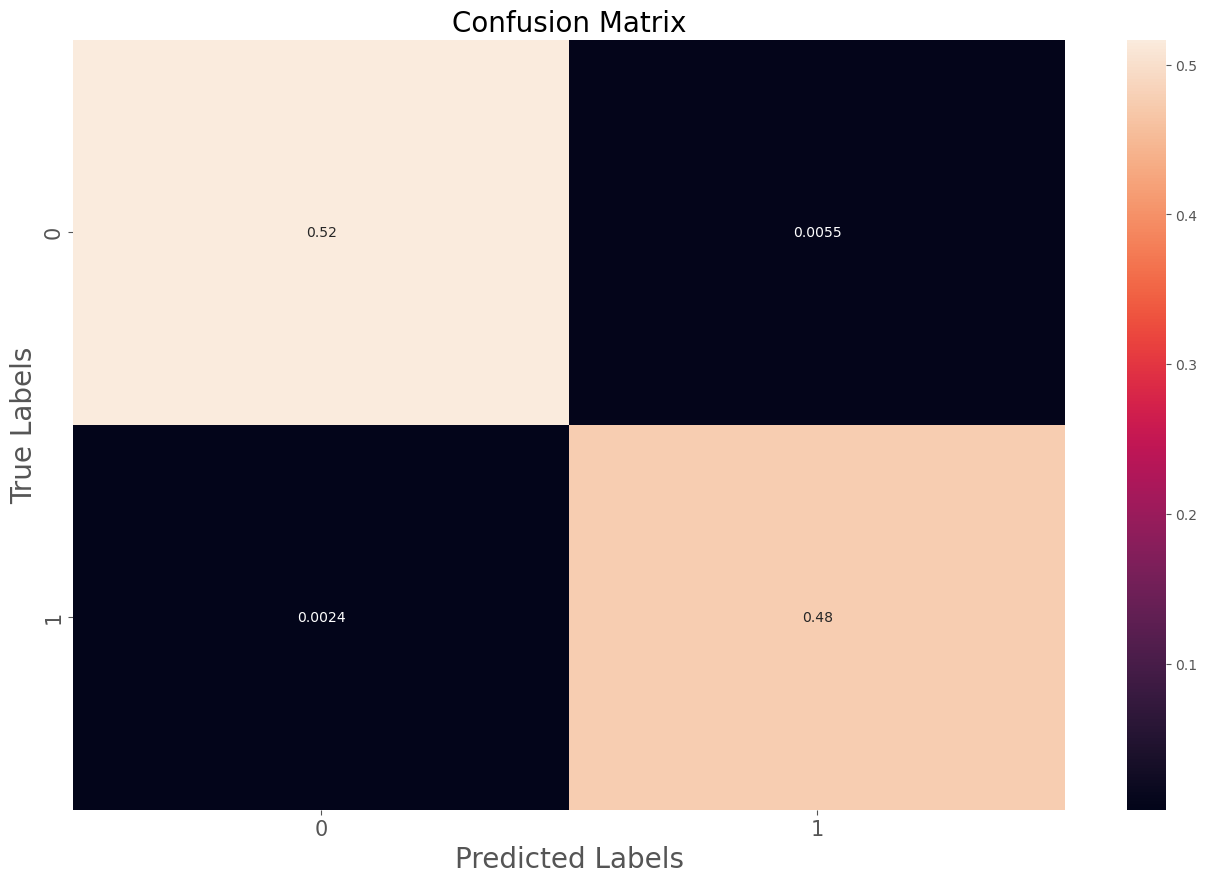

In [24]:
matrix = confusion_matrix(binary_predictions, y_test, normalize='all')
plt.figure(figsize=(16, 10))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax)

# labels, title and ticks
ax.set_xlabel('Predicted Labels', size=20)
ax.set_ylabel('True Labels', size=20)
ax.set_title('Confusion Matrix', size=20) 
ax.xaxis.set_ticklabels([0,1], size=15)
ax.yaxis.set_ticklabels([0,1], size=15)